In [1]:
%%time
from concurrent.futures import ProcessPoolExecutor
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from statistics import mean 
import time
import torch

import sys
script_path = os.path.abspath("pyscripts")
if script_path not in sys.path:
    sys.path.append(script_path)
from utils import *
from load_data import *
from lstm import *

CPU times: user 2.56 s, sys: 2.47 s, total: 5.03 s
Wall time: 842 ms


# 1. Parameters

In [2]:
# time sequence
train_window = 48
input_size = 1
output_size = 24
hidden_size = 48
num_layers = 2
learning_rate = 0.005

# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Read Data

In [3]:
obs = np.load('/home/graduate/fbx5002/disk10TB/IEE/IoT_Weather_Data/Geotab_Obs.npy')
# swap rows and columns, obs = np.swapaxes(obs, 0, 1)
obs = obs.T
times = np.load('/home/graduate/fbx5002/disk10TB/IEE/IoT_Weather_Data/Geotab_Obs_TS.npy')
times = [datetime.utcfromtimestamp(x.tolist()/1e9) for x in times]
stations = pd.read_csv('/home/graduate/fbx5002/disk10TB/IEE/IoT_Weather_Data/selected_Geotab_stations.csv')
stations = stations[stations.columns[[3,1,2,4]]]
#stations_remove = np.load('/home/graduate/fbx5002/disk10TB/IEE/IoT_Weather_Data/stations_remove.npy')

weather_station_2015_2020 = pd.read_csv("/home/graduate/fbx5002/disk10TB/IEE/IoT_Weather_Data/weather_station_2015_2020.csv")
weather_time_2015_2020 = np.load('/home/graduate/fbx5002/disk10TB/IEE/IoT_Weather_Data/weather_time_2015_2020.npy', allow_pickle=True)
weather_obs_2015_2020 = np.load('/home/graduate/fbx5002/disk10TB/IEE/IoT_Weather_Data/weather_obs_2015_2020.npy')

In [4]:
stations5 = set(stations.sort_values('missing')[:455]['geohash'])
stations10= set(stations.sort_values('missing')[:1650]['geohash'])
stations15= set(stations.sort_values('missing')[:2107]['geohash'])
stations20= set(stations['geohash'])
wu_stations = set(weather_station_2015_2020['station'])

In [ ]:
after_missingratio = list(map(lambda x: sum(np.isnan(x))/8784, obs))
print("The data shape of IoT and Weather_Underground data are %s, %s" %(obs.shape, weather_obs_2015_2020.shape))
print("The time length of IoT and Weather_Underground data are %s, %s" % (len(times), len(weather_time_2015_2020)))
print("Time window of IoT and Weather_Underground data are [%s, %s], [%s, %s]" % 
      (times[0].strftime("%Y%m%d%H"), times[-1].strftime("%Y%m%d%H"), 
       weather_time_2015_2020[0].strftime("%Y%m%d"), weather_time_2015_2020[-1].strftime("%Y%m%d")))
print("Original Minimum and Maximum Missing Data Ratio for IoT Stations are %s, %s" % (min(stations['missing']), max(stations['missing'])))
print("After Interpolation, Minimum and Maximum Missing Data Ratio for IoT Stations are %s, %s" % (min(after_missingratio), max(after_missingratio)))
print(stations.head(5)); print(weather_station_2015_2020.head(5))

In [ ]:
# select days for testing
test_times = []
for _time in times:
    if _time.hour > 0:
        continue
    test_times.append(datetime(_time.year, _time.month, _time.day, 0 , 0))
random.seed(7)
seq = [i for i in range(len(test_times))]
random.shuffle(seq) # inplace shuffle
test_times = np.array(sorted([test_times[i] for i in seq[:30]]))
print(test_times)

# 3. Create infos dict and Calculate min and max

In [ ]:
infos = {}
for i, station in enumerate(stations['geohash']):
    infos[station] = obs[i]
print(list(infos.items())[:2])

# operations below will in-place rewrite infos variable
norm_min = []
norm_max = []
for key, value in infos.items():
    norm_min.append(min(value))
    norm_max.append(max(value))
# len(list(infos_filtered.items())[0][1]) # this is the station we used for the single station training
norm_min = min(norm_min)
norm_max = max(norm_max)
print("The minimum and maximal temperatures for IoT stations are %.2f, %.2f" %(norm_min, norm_max))

In [ ]:
infos_w = {}
for i, station in enumerate(weather_station_2015_2020['station']):
    infos_w[station] = weather_obs_2015_2020[i]
print(list(infos_w.items())[:2])

# operations below will in-place rewrite infos variable
norm_min_w = []
norm_max_w = []
for key, value in infos_w.items():
    norm_min_w.append(min(value))
    norm_max_w.append(max(value))
# len(list(infos_filtered.items())[0][1]) # this is the station we used for the single station training
norm_min_w = min(norm_min_w)
norm_max_w = max(norm_max_w)
print("The minimum and maximal temperatures for Weather Underground stations are %.2f, %.2f" %(norm_min_w, norm_max_w))

In [ ]:
norm_min = min(norm_min, norm_min_w)
norm_max = max(norm_max, norm_max_w)
print(norm_min, norm_max)

# 4. Split data for test_day and train_day for IoT stations

### key point
- only need to make sure the 24 hours output for test_times not seen in the training dataset
- the 48 hours input of test_times can be seen in the training dataset
- weather underground stations all for training

In [ ]:
test_time_range = []
for testtime in test_times:
    start = testtime - timedelta(hours = train_window)
    end = testtime + timedelta(hours = output_size-1) # include itself
    if end > times[-1]:
        continue
    test_time_range.append((start, end))
    
test_time_index = sorted([(times.index(x), times.index(y)) for x, y in test_time_range])
removed_time_index = sorted([(times.index(x)+train_window, times.index(y)) for x, y in test_time_range])
print(test_time_index[:5])
print(removed_time_index[:5])

In [ ]:
test_data = {}
train_data = {}
for key, data in list(infos.items()):
    test, train = [], []
    for test_time in test_time_index:
        test.append(data[test_time[0]:(test_time[1]+1)])
    
    for i in range(len(removed_time_index)):
        if i ==0:
            end = removed_time_index[0][0]
            train.append(data[:end])   
        else:
            start = removed_time_index[i-1][1]+1
            end = removed_time_index[i][0]
            train.append(data[start:end])
    # add elements after last removed_time_index
    start = removed_time_index[len(removed_time_index)-1][1]+1
    train.append(data[start:])
    # change to nparray
    train_data[key] = train
    test_data[key] = test

#len(infos['dr72rzt'][0]) == len(train_data['dr72rzt'][0]) + len(test_data['dr72rzt'][0]) 
l1 = sum([len(x) for x in train_data['dr72rzt']])
l2 = sum([y-x+1 for x, y in removed_time_index])
print(l1, l2)
l1+l2 == len(infos['dr72rzt'])

# 5. Prepare training and test tensors

In [ ]:
start = time.time()
train_data.update(infos_w)
train_tensors = Dataset(train_data, (norm_min, norm_max), train_window, output_size)
end = time.time()
print(end-start)
print("Training input and output for a IoT station: %s, %s" % (train_tensors[0][0].shape, train_tensors[0][1].shape))
print("Validation input and output for a IoT station: %s, %s" % (train_tensors[0][2].shape, train_tensors[0][3].shape))
idx = train_tensors.keys.index('KNJCLIFF7')
print("Training input and output for a weather station: %s, %s" % (train_tensors[idx][0].shape, train_tensors[idx][1].shape))
print("Validation input and output for a weather station: %s, %s" % (train_tensors[idx][2].shape, train_tensors[idx][3].shape))

In [ ]:
start = time.time()
test_tensors = DatasetTestDays(test_data, (norm_min, norm_max), train_window)
end = time.time()
print(end-start)
print("Testing input and output for one IoT station: %s, %s" % (test_tensors[0][0].shape, test_tensors[0][1].shape))

In [ ]:
# three selected days have na values in their observations which cannot be predicted
missing_days = np.unique(test_tensors.missing)
print(missing_days)
test_times = np.delete(test_times, missing_days)

In [ ]:
db = {'train': train_tensors, 'test': test_tensors, 'selected_days': test_times}
torch.save(db, './checkpoint/IoT_final/TensorData/Torch_db')

# 6. Train LSTM 

In [5]:
# To compute the number of trainable parameters
# dir() or __dir__:return an alphabetized list of names comprising (some of) the attributes of the given object, and of attributes reachable from it
# dir() or __dir__:return an alphabetized list of names comprising (some of) the attributes of the given object, and of attributes reachable from it
# print(dir(list(model.parameters())[0]))
_, model, _ = initial_model(input_size, output_size, hidden_size, num_layers, learning_rate, device)
totalTrainable = []
for name, p in model.named_parameters():
    print(name, p.shape)
    # total number of trainable parameters
    if p.requires_grad:
        totalTrainable.append(p.numel())
    else:
        totalTrainable.append(None)
        
print(totalTrainable)

num_epochs = 101
epoch_interval = 2

lstm.weight_ih_l0 torch.Size([192, 1])
lstm.weight_hh_l0 torch.Size([192, 48])
lstm.bias_ih_l0 torch.Size([192])
lstm.bias_hh_l0 torch.Size([192])
lstm.weight_ih_l1 torch.Size([192, 48])
lstm.weight_hh_l1 torch.Size([192, 48])
lstm.bias_ih_l1 torch.Size([192])
lstm.bias_hh_l1 torch.Size([192])
linear.weight torch.Size([24, 48])
linear.bias torch.Size([24])
[192, 9216, 192, 192, 9216, 9216, 192, 192, 1152, 24]


In [ ]:
# initialize and train the model for 5.5%
checkpoint_format = './checkpoint/IoT_final/checkpoint-5.5-{epoch}.pth.tar'
loss_func, model, optimizer = initial_model(input_size, output_size, hidden_size, num_layers, learning_rate, device) 
Training(loss_func, model, optimizer, train_tensors, num_epochs, epoch_interval, checkpoint_format, device, stationlist = stations5)

In [ ]:
# initialize and train the model for 10%
checkpoint_format = './checkpoint/IoT_final/checkpoint-10-{epoch}.pth.tar'
loss_func, model, optimizer = initial_model(input_size, output_size, hidden_size, num_layers, learning_rate, device) 
Training(loss_func, model, optimizer, train_tensors, num_epochs, epoch_interval, checkpoint_format, device, stationlist = stations10)

In [ ]:
# initialize and train the model for 20%
checkpoint_format = './checkpoint/IoT_final/checkpoint-20-{epoch}.pth.tar'
loss_func, model, optimizer = initial_model(input_size, output_size, hidden_size, num_layers, learning_rate, device) 
Training(loss_func, model, optimizer, train_tensors, num_epochs, epoch_interval, checkpoint_format, 
         device, stationlist = stations20)

In [ ]:
# initialize and train the model for 10%IoT+WU
checkpoint_format = './checkpoint/IoT_final/checkpoint-IoT-W-{epoch}.pth.tar'
loss_func, model, optimizer = initial_model(input_size, output_size, hidden_size, num_layers, learning_rate, device) 
Training(loss_func, model, optimizer, train_tensors, num_epochs, epoch_interval, checkpoint_format,
         device, stationlist = stations10.union(wu_stations))

# 7. Predict and Statistic Analysis_SplitByDay

In [7]:
# read save data
loaded = torch.load('./checkpoint/IoT_final/TensorData/Torch_db5WU')
train_tensors = loaded['train']
test_tensors = loaded['test']
test_times = loaded['selected_days']
norm_min, norm_max = train_tensors.min, train_tensors.max
print(norm_min, norm_max)

print("Training input and output for a IoT station: %s, %s" % (train_tensors[0][0].shape, train_tensors[0][1].shape))
print("Validation input and output for a IoT station: %s, %s" % (train_tensors[0][2].shape, train_tensors[0][3].shape))
idx = train_tensors.keys.index('KNJCLIFF7')
print("Training input and output for a weather station: %s, %s" % (train_tensors[idx][0].shape, train_tensors[idx][1].shape))
print("Validation input and output for a weather station: %s, %s" % (train_tensors[idx][2].shape, train_tensors[idx][3].shape))

-29.632716049382715 48.0
Training input and output for a IoT station: torch.Size([4307, 48, 1]), torch.Size([4307, 24, 1])
Validation input and output for a IoT station: torch.Size([479, 48, 1]), torch.Size([479, 24, 1])
Training input and output for a weather station: torch.Size([78171, 48, 1]), torch.Size([78171, 24, 1])
Validation input and output for a weather station: torch.Size([8686, 48, 1]), torch.Size([8686, 24, 1])


In [7]:
# read the saved model and use the best one for predicting
checkpoint5 = torch.load('./checkpoint/IoT_final/checkpoint-5.5-{epoch}.pth.tar'.format(epoch=60))
checkpoint10 = torch.load('./checkpoint/IoT_final/checkpoint-10-{epoch}.pth.tar'.format(epoch=23))
checkpoint15 = torch.load('./checkpoint/IoT_final/checkpoint-15-{epoch}.pth.tar'.format(epoch=8))
checkpoint20 = torch.load('./checkpoint/IoT_final/checkpoint-20-{epoch}.pth.tar'.format(epoch=7))
checkpointIoTWU = torch.load('./checkpoint/IoT_final/checkpoint-IoT-W-{epoch}.pth.tar'.format(epoch=8))
# initialize and train the model
_, model5, _ = initial_model(input_size, output_size, hidden_size, num_layers, learning_rate, device)
_, model10, _ = initial_model(input_size, output_size, hidden_size, num_layers, learning_rate, device)
_, model15, _ = initial_model(input_size, output_size, hidden_size, num_layers, learning_rate, device)
_, model20, _ = initial_model(input_size, output_size, hidden_size, num_layers, learning_rate, device)
_, modelIoTWU, _ = initial_model(input_size, output_size, hidden_size, num_layers, learning_rate, device)
model5.load_state_dict(checkpoint5['bestLossModel'])
model10.load_state_dict(checkpoint10['bestLossModel'])
model15.load_state_dict(checkpoint15['bestLossModel'])
model20.load_state_dict(checkpoint20['bestLossModel'])
modelIoTWU.load_state_dict(checkpointIoTWU['bestLossModel'])

<All keys matched successfully>

<function matplotlib.pyplot.show(close=None, block=None)>

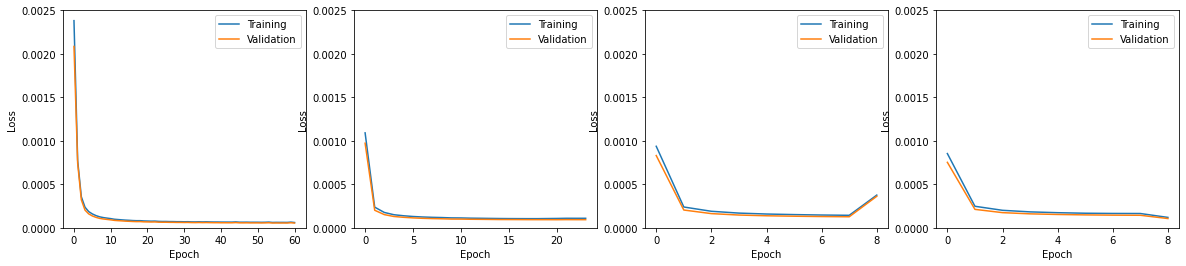

In [8]:
checkpoints = [checkpoint5, checkpoint10, checkpoint15,checkpoint20]
stations_ = [stations5, stations10, stations15, stations20]
fig, axs = plt.subplots(1, 4, figsize=(20,4))
for i, ax in enumerate(axs):   
    ax.plot(meanLossEpoch(checkpoints[i]['train_loss'], len(stations_[i])))
    ax.plot(meanLossEpoch(checkpoints[i]['test_loss'], len(stations_[i])))
    ax.set_ylim([0, 0.0025])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend(["Training", "Validation"])
plt.savefig('LossThreeRatios.jpeg', dpi=300)
plt.show 

## Compare four models on 5.5% stations

In [9]:
test_pred_orig_dict5 = predict(model5, test_tensors, (norm_min, norm_max), device, stationlist = stations5)
test_pred_orig_dict10 = predict(model10, test_tensors, (norm_min, norm_max), device, stationlist = stations5)
test_pred_orig_dict15 = predict(model15, test_tensors, (norm_min, norm_max), device, stationlist = stations5)
test_pred_orig_dict20 = predict(model20, test_tensors, (norm_min, norm_max), device, stationlist = stations5)
# calculate root mean squared error
testScores_stations5, test_min5, test_mean5, test_max5 = stat_scores(test_pred_orig_dict5)
testScores_stations10, test_min10, test_mean10, test_max10 = stat_scores(test_pred_orig_dict10)
testScores_stations15, test_min15, test_mean15, test_max15 = stat_scores(test_pred_orig_dict15)
testScores_stations20, test_min20, test_mean20, test_max20= stat_scores(test_pred_orig_dict20)

Minimum, Mean and Maximum RMSE/MAE for Testing Stations are: (3.4387644436254536, 2.3407304286956787), (3.876985102985248, 2.670888900756836), (4.310313237041598, 2.949211597442627)
Minimum, Mean and Maximum RMSE/MAE for Testing Stations are: (3.412777726606036, 2.409334421157837), (3.77913083049322, 2.7551872730255127), (4.33056241477329, 3.220960855484009)
Minimum, Mean and Maximum RMSE/MAE for Testing Stations are: (3.2225732411184325, 2.3598413467407227), (3.6363234095082353, 2.628476858139038), (4.105673163322117, 2.971999168395996)
Minimum, Mean and Maximum RMSE/MAE for Testing Stations are: (3.2506330313763954, 2.4456987380981445), (3.839813822166878, 2.842639207839966), (4.319781803695989, 3.079951047897339)


In [10]:
test_pred_orig_dict = predict(modelIoTWU, test_tensors, (norm_min, norm_max), device, stationlist = stations5)
# calculate root mean squared error
testScores_stations, test_min, test_mean, test_max = stat_scores(test_pred_orig_dict)

Minimum, Mean and Maximum RMSE/MAE for Testing Stations are: (2.7145800126222066, 1.879504919052124), (3.0732030875134253, 2.123457431793213), (3.668009959874, 2.576258897781372)


## Check Manzhu's result

In [6]:
# two dataset used different norm_min, norm_max
# read save data
loaded5 = torch.load('./checkpoint/IoT_final/TensorData/Torch_db5WU')
train_tensors5 = loaded5['train']
test_tensors5 = loaded5['test']
test_times5 = loaded5['selected_days']
norm_min5, norm_max5 = train_tensors5.min, train_tensors5.max
print(norm_min5, norm_max5)

# read save data
loaded10 = torch.load('./checkpoint/IoT_final/TensorData/Torch_db10WU')
train_tensors10 = loaded10['train']
test_tensors10 = loaded10['test']
test_times10 = loaded10['selected_days']
norm_min10, norm_max10 = train_tensors10.min, train_tensors10.max
print(norm_min10, norm_max10)

-22.55 48.0
-29.632716049382715 48.0


In [7]:
checkpoint5 = torch.load('./checkpoint/IoT_final/checkpoint-5.5-{epoch}.pth.tar'.format(epoch=60))
checkpoint10 = torch.load('./checkpoint/IoT_final/checkpoint-10-{epoch}.pth.tar'.format(epoch=23))
checkpoint15 = torch.load('./checkpoint/IoT_final/checkpoint-15-{epoch}.pth.tar'.format(epoch=8))
checkpoint20 = torch.load('./checkpoint/IoT_final/checkpoint-20-{epoch}.pth.tar'.format(epoch=7))

checkpoint5IoT5WU = torch.load('./checkpoint/IoT_final/checkpoint-5.5-IoT-5-W-{epoch}.pth.tar'.format(epoch=18))
checkpoint10IoT5WU = torch.load('./checkpoint/IoT_final/checkpoint-10-IoT-5-W-{epoch}.pth.tar'.format(epoch=9))
checkpoint15IoT5WU = torch.load('./checkpoint/IoT_final/checkpoint-15-IoT-5-W-{epoch}.pth.tar'.format(epoch=5))
checkpoint20IoT5WU = torch.load('./checkpoint/IoT_final/checkpoint-20-IoT-5-W-{epoch}.pth.tar'.format(epoch=7))

checkpoint5IoT10WU = torch.load('./checkpoint/IoT_final/checkpoint-5.5-IoT-10-W-{epoch}.pth.tar'.format(epoch=15))
checkpoint10IoT10WU = torch.load('./checkpoint/IoT_final/checkpoint-10-IoT-10-W-{epoch}.pth.tar'.format(epoch=12))
checkpoint15IoT10WU = torch.load('./checkpoint/IoT_final/checkpoint-15-IoT-10-W-{epoch}.pth.tar'.format(epoch=5))
checkpoint20IoT10WU = torch.load('./checkpoint/IoT_final/checkpoint-20-IoT-10-W-{epoch}.pth.tar'.format(epoch=3))


_, model5, _ = initial_model(input_size, output_size, hidden_size, num_layers, learning_rate, device)
_, model10, _ = initial_model(input_size, output_size, hidden_size, num_layers, learning_rate, device)
_, model15, _ = initial_model(input_size, output_size, hidden_size, num_layers, learning_rate, device)
_, model20, _ = initial_model(input_size, output_size, hidden_size, num_layers, learning_rate, device)

_, model5IoT5WU, _ = initial_model(input_size, output_size, hidden_size, num_layers, learning_rate, device)
_, model10IoT5WU, _ = initial_model(input_size, output_size, hidden_size, num_layers, learning_rate, device)
_, model15IoT5WU, _ = initial_model(input_size, output_size, hidden_size, num_layers, learning_rate, device)
_, model20IoT5WU, _ = initial_model(input_size, output_size, hidden_size, num_layers, learning_rate, device)

_, model5IoT10WU, _ = initial_model(input_size, output_size, hidden_size, num_layers, learning_rate, device)
_, model10IoT10WU, _ = initial_model(input_size, output_size, hidden_size, num_layers, learning_rate, device)
_, model15IoT10WU, _ = initial_model(input_size, output_size, hidden_size, num_layers, learning_rate, device)
_, model20IoT10WU, _ = initial_model(input_size, output_size, hidden_size, num_layers, learning_rate, device)


model5.load_state_dict(checkpoint5['bestLossModel'])
model10.load_state_dict(checkpoint10['bestLossModel'])
model15.load_state_dict(checkpoint15['bestLossModel'])
model20.load_state_dict(checkpoint20['bestLossModel'])

model5IoT5WU.load_state_dict(checkpoint5IoT5WU['bestLossModel'])
model10IoT5WU.load_state_dict(checkpoint10IoT5WU['bestLossModel'])
model15IoT5WU.load_state_dict(checkpoint15IoT5WU['bestLossModel'])
model20IoT5WU.load_state_dict(checkpoint20IoT5WU['bestLossModel'])

model5IoT10WU.load_state_dict(checkpoint5IoT10WU['bestLossModel'])
model10IoT10WU.load_state_dict(checkpoint10IoT10WU['bestLossModel'])
model15IoT10WU.load_state_dict(checkpoint15IoT10WU['bestLossModel'])
model20IoT10WU.load_state_dict(checkpoint20IoT10WU['bestLossModel'])

<All keys matched successfully>

testScores_stations5, test_min5, test_mean5, test_max5 = stat_scores(test_pred_orig_dict5)
testScores_stations10, test_min10, test_mean10, test_max10 = stat_scores(test_pred_orig_dict10)
testScores_stations15, test_min15, test_mean15, test_max15 = stat_scores(test_pred_orig_dict15)
testScores_stations20, test_min20, test_mean20, test_max20= stat_scores(test_pred_orig_dict20)
print('\n')
testScores_stations5_5WU, test_min5_5WU, test_mean5_5WU, test_max5_5WU = stat_scores(test_pred_orig_dict5_5WU)
testScores_stations10_5WU, test_min10_5WU, test_mean10_5WU, test_max10_5WU = stat_scores(test_pred_orig_dict10_5WU)
testScores_stations15_5WU, test_min15_5WU, test_mean15_5WU, test_max15_5WU = stat_scores(test_pred_orig_dict15_5WU)
testScores_stations20_5WU, test_min20_5WU, test_mean20_5WU, test_max20_5WU= stat_scores(test_pred_orig_dict20_5WU)
print('\n')
testScores_stations5_10WU, test_min5_10WU, test_mean5_10WU, test_max5_10WU = stat_scores(test_pred_orig_dict5_10WU)
testScores_stations10_10WU, test_min10_10WU, test_mean10_10WU, test_max10_10WU = stat_scores(test_pred_orig_dict10_10WU)
testScores_stations15_10WU, test_min15_10WU, test_mean15_10WU, test_max15_10WU = stat_scores(test_pred_orig_dict15_10WU)
testScores_stations20_10WU, test_min20_10WU, test_mean20_10WU, test_max20_10WU= stat_scores(test_pred_orig_dict20_10WU)

In [8]:
test_pred_orig_dict5 = predict(model5, test_tensors5, (norm_min5, norm_max5), device, stationlist = stations5)
test_pred_orig_dict10 = predict(model10, test_tensors5, (norm_min5, norm_max5), device, stationlist = stations5)
test_pred_orig_dict15 = predict(model15, test_tensors5, (norm_min5, norm_max5), device, stationlist = stations5)
test_pred_orig_dict20 = predict(model20, test_tensors5, (norm_min5, norm_max5), device, stationlist = stations5)

test_pred_orig_dict5_5WU = predict(model5IoT5WU, test_tensors5, (norm_min5, norm_max5), device, stationlist = stations5)
test_pred_orig_dict10_5WU = predict(model10IoT5WU, test_tensors5, (norm_min5, norm_max5), device, stationlist = stations5)
test_pred_orig_dict15_5WU = predict(model15IoT5WU, test_tensors5, (norm_min5, norm_max5), device, stationlist = stations5)
test_pred_orig_dict20_5WU = predict(model20IoT5WU, test_tensors5, (norm_min5, norm_max5), device, stationlist = stations5)

test_pred_orig_dict5_10WU = predict(model5IoT10WU, test_tensors10, (norm_min10, norm_max10), device, stationlist = stations5)
test_pred_orig_dict10_10WU = predict(model10IoT10WU, test_tensors10, (norm_min10, norm_max10), device, stationlist = stations5)
test_pred_orig_dict15_10WU = predict(model15IoT10WU, test_tensors10, (norm_min10, norm_max10), device, stationlist = stations5)
test_pred_orig_dict20_10WU = predict(model20IoT10WU, test_tensors10, (norm_min10, norm_max10), device, stationlist = stations5)

# test_pred_orig_dict5_10WU = predict(model5IoT10WU, test_tensors5, (norm_min5, norm_max5), device, stationlist = stations5)
# test_pred_orig_dict10_10WU = predict(model10IoT10WU, test_tensors5, (norm_min5, norm_max5), device, stationlist = stations5)
# test_pred_orig_dict15_10WU = predict(model15IoT10WU, test_tensors5, (norm_min5, norm_max5), device, stationlist = stations5)
# test_pred_orig_dict20_10WU = predict(model20IoT10WU, test_tensors5, (norm_min5, norm_max5), device, stationlist = stations5)

##################################
_,_,_,_ = stat_scores(test_pred_orig_dict5)
_,_,_,_ = stat_scores(test_pred_orig_dict10)
_,_,_,_ = stat_scores(test_pred_orig_dict15)
_,_,_,_ = stat_scores(test_pred_orig_dict20)
print('\n')
_,_,_,_ = stat_scores(test_pred_orig_dict5_5WU)
_,_,_,_ = stat_scores(test_pred_orig_dict10_5WU)
_,_,_,_ = stat_scores(test_pred_orig_dict15_5WU)
_,_,_,_ = stat_scores(test_pred_orig_dict20_5WU)
print('\n')
_,_,_,_ = stat_scores(test_pred_orig_dict5_10WU)
_,_,_,_ = stat_scores(test_pred_orig_dict10_10WU)
_,_,_,_ = stat_scores(test_pred_orig_dict15_10WU)
_,_,_,_ = stat_scores(test_pred_orig_dict20_10WU)

Minimum, Mean and Maximum RMSE/MAE for Testing Stations are: (3.4387644436254536, 2.3407304286956787), (3.876985102985248, 2.670888900756836), (4.310313237041598, 2.949211597442627)
Minimum, Mean and Maximum RMSE/MAE for Testing Stations are: (3.412777726606036, 2.409334421157837), (3.77913083049322, 2.7551872730255127), (4.33056241477329, 3.220960855484009)
Minimum, Mean and Maximum RMSE/MAE for Testing Stations are: (3.2225732411184325, 2.3598413467407227), (3.6363234095082353, 2.628476858139038), (4.105673163322117, 2.971999168395996)
Minimum, Mean and Maximum RMSE/MAE for Testing Stations are: (3.2506330313763954, 2.4456987380981445), (3.839813822166878, 2.842639207839966), (4.319781803695989, 3.079951047897339)


Minimum, Mean and Maximum RMSE/MAE for Testing Stations are: (2.606095680406721, 1.842820167541504), (3.18259905856489, 2.2648518085479736), (3.9106587669179182, 2.700509548187256)
Minimum, Mean and Maximum RMSE/MAE for Testing Stations are: (2.5973128701323653, 1.9310272

In [9]:
test_pred_orig_dict10 = predict(model10, test_tensors5, (norm_min5, norm_max5), device, stationlist = stations10)
test_pred_orig_dict10_5WU = predict(model10IoT5WU, test_tensors5, (norm_min5, norm_max5), device, stationlist = stations10)
test_pred_orig_dict10_10WU = predict(model10IoT10WU, test_tensors10, (norm_min10, norm_max10), device, stationlist = stations10)

test_pred_orig_dict15 = predict(model15, test_tensors5, (norm_min5, norm_max5), device, stationlist = stations15)
test_pred_orig_dict15_5WU = predict(model15IoT5WU, test_tensors5, (norm_min5, norm_max5), device, stationlist = stations15)
test_pred_orig_dict15_10WU = predict(model15IoT10WU, test_tensors10, (norm_min10, norm_max10), device, stationlist = stations15)

test_pred_orig_dict20 = predict(model20, test_tensors5, (norm_min5, norm_max5), device, stationlist = stations20)
test_pred_orig_dict20_5WU = predict(model20IoT5WU, test_tensors5, (norm_min5, norm_max5), device, stationlist = stations20)
test_pred_orig_dict20_10WU = predict(model20IoT10WU, test_tensors10, (norm_min10, norm_max10), device, stationlist = stations20)

##############################
_,_,_,_ = stat_scores(test_pred_orig_dict10)
_,_,_,_ = stat_scores(test_pred_orig_dict10_5WU)
_,_,_,_ = stat_scores(test_pred_orig_dict10_10WU)
print('\n')
_,_,_,_ = stat_scores(test_pred_orig_dict15)
_,_,_,_= stat_scores(test_pred_orig_dict15_5WU)
_,_,_,_ = stat_scores(test_pred_orig_dict10_10WU)
print('\n')
_,_,_,_= stat_scores(test_pred_orig_dict20)
_,_,_,_= stat_scores(test_pred_orig_dict20_5WU)
_,_,_,_ = stat_scores(test_pred_orig_dict10_10WU)

Minimum, Mean and Maximum RMSE/MAE for Testing Stations are: (2.974440732046452, 2.249952793121338), (3.8249538443778763, 2.7707934379577637), (4.33056241477329, 3.220960855484009)
Minimum, Mean and Maximum RMSE/MAE for Testing Stations are: (2.585607501868186, 1.876233696937561), (3.097661483779469, 2.2609384059906006), (3.6585640390653125, 2.623060464859009)
Minimum, Mean and Maximum RMSE/MAE for Testing Stations are: (2.9121404859798585, 2.116349935531616), (3.514823720535354, 2.5380074977874756), (3.8934851248645477, 2.842907428741455)


Minimum, Mean and Maximum RMSE/MAE for Testing Stations are: (3.078525730131477, 2.3276076316833496), (3.7114140575993138, 2.7115671634674072), (4.407029103327788, 3.298968553543091)
Minimum, Mean and Maximum RMSE/MAE for Testing Stations are: (2.7619946462039313, 2.0050010681152344), (3.337225564824772, 2.434685707092285), (4.157285632985604, 2.8132243156433105)
Minimum, Mean and Maximum RMSE/MAE for Testing Stations are: (2.9121404859798585, 2.11

In [ ]:
# # ##### plot baseline and predictions for test station having max RMSE
# # fig, axs = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(14,10))
# # i  =0
# # for row in axs:
# #     for col in row:
# #         col.plot(test_pred_orig_dict[test_mean][1][i]) # original
# #         col.plot(test_pred_orig_dict[test_mean][0][i], '--') # predicted
# #         i+=1

# errors_rmse = list(map(lambda x, y : math.sqrt(mean_squared_error(x, y)), 
#                                 test_pred_orig_dict[test_mean][0],test_pred_orig_dict[test_mean][1]))
# errors_mae = list(map(lambda x, y : mean(abs(x- y).numpy()), 
#                                 test_pred_orig_dict[test_mean][0],test_pred_orig_dict[test_mean][1]))
# print(sorted(errors_rmse, reverse=True))
# print(sorted(errors_mae, reverse=True))
# print("\n")
# print("Average RMSE over 27 selected days is %s" % mean(errors_rmse))
# idx = [i for i, error in enumerate(errors_rmse) if error > 1.5*mean(errors_rmse)]
# outlier_times = sorted([test_times[i] for i in idx])
# print(outlier_times)

# weights = np.ones_like(errors_rmse) / (len(errors_rmse))
# fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))
# ax1.hist(errors_rmse, bins = 20, range=(0.5, 8), edgecolor = 'black', weights= weights)
# ax1.set_xlabel('Average RMSE for Each Selected Day')
# ax1.set_ylabel('Percentage')
# ax1.set_ylim(0, 0.3)
# ax2.hist(errors_mae, bins = 20, range=(0.5, 8), edgecolor = 'black', weights= weights)
# ax2.set_xlabel('Average MAE for Each Selected Day')
# ax2.set_ylabel('Percentage')
# plt.savefig('HistRMSEDays.jpeg', dpi=300)
# plt.show()

# testScores_stations = dict()
# idx = [error < 1.5*mean(errors_rmse) for error in errors_rmse]
# testScores_stations, test_min_, test_mean_, test_max_  = stat_scores(test_pred_orig_dict, idx)
# print("Test Stations with min, mean and max RMSE are %s, %s, %s" % (test_min_, test_mean_, test_max_))

# # mae over predicted time points for test station with mean error
# over_time_mae = np.mean(abs(test_pred_orig_dict[test_mean][0][idx] - test_pred_orig_dict[test_mean][1][idx]).numpy(), axis =0)
# print(over_time_mae)
# plt.plot(over_time_mae)
# plt.show()

## Compare model10 and model IoTWU to predict on 10% stations

In [ ]:
test_pred_orig_dict10 = predict(model10, test_tensors, (norm_min, norm_max), device, stationlist = stations10)
# calculate root mean squared error
testScores_stations10, test_min10, test_mean10, test_max10 = stat_scores(test_pred_orig_dict10)

test_pred_orig_dict = predict(modelIoTWU, test_tensors, (norm_min, norm_max), device, stationlist = stations10)
# calculate root mean squared error
testScores_stations, test_min, test_mean, test_max = stat_scores(test_pred_orig_dict)

In [ ]:
errors_rmse = list(map(lambda x, y : math.sqrt(mean_squared_error(x, y)), 
                                test_pred_orig_dict[test_mean][0],test_pred_orig_dict[test_mean][1]))
errors_mae = list(map(lambda x, y : mean(abs(x- y).numpy()), 
                                test_pred_orig_dict[test_mean][0],test_pred_orig_dict[test_mean][1]))
print(sorted([(errors_rmse[i], test_times[i]) for i in range(len(test_times))], reverse=True))
print(sorted([(errors_mae[i], test_times[i]) for i in range(len(test_times))], reverse=True))
print("\n")
print("Average RMSE over 27 selected days is %s" % mean(errors_rmse))

idx = [i for i, error in enumerate(errors_rmse) if error > 1.5*mean(errors_rmse)]
outlier_times = sorted([(test_times[i], errors_rmse[i]) for i in idx])
print(idx, outlier_times)

In [ ]:
weights = np.ones_like(errors_rmse) / (len(errors_rmse))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))
ax1.hist(errors_rmse, bins = 20, range=(0.5, 9), edgecolor = 'black', weights= weights)
ax1.set_xlabel('Average RMSE for Each Selected Day')
ax1.set_ylabel('Percentage')
ax1.set_ylim(0, 0.27)
ax2.hist(errors_mae, bins = 20, range=(0.5, 9), edgecolor = 'black', weights= weights)
ax2.set_xlabel('Average MAE for Each Selected Day')
ax2.set_ylabel('Percentage')
ax1.set_ylim(0, 0.27)
plt.savefig('HistRMSEDays.jpeg', dpi=300)
plt.show()

In [ ]:
testScores_stations = dict()
idx = [error < 1.5*mean(errors_rmse) for error in errors_rmse]
testScores_stations, test_min_, test_mean_, test_max_  = stat_scores(test_pred_orig_dict, idx)
print("Test Stations with min, mean and max RMSE are %s, %s, %s" % (test_min_, test_mean_, test_max_))

# save predicted result to nparray

In [ ]:
# test_stations are not shuffled
outputStations = stations[stations['geohash'].isin(list(test_pred_orig_dict.keys()))]
list(outputStations['geohash'])== list(test_pred_orig_dict.keys())

In [ ]:
outputStations.to_csv('/media/fbx5002/CodeMonkey/IEE/IoT_Weather_Data/deliverables/stations.csv', index=False)

np.save('/media/fbx5002/CodeMonkey/IEE/IoT_Weather_Data/deliverables/selectedDates.npy', test_times)
np.save('/media/fbx5002/CodeMonkey/IEE/IoT_Weather_Data/deliverables/predictions.npy', 
        np.array([x[0].numpy() for x in list(test_pred_orig_dict.values())]))
np.save('/media/fbx5002/CodeMonkey/IEE/IoT_Weather_Data/deliverables/observations.npy', 
        np.array([x[1].numpy() for x in list(test_pred_orig_dict.values())]))

# 7. Prepare training and test tensors splitted by stations, Train LSTM

In [ ]:
train_stations = list(infos.keys())[:int(len(infos) * 0.7)]
test_stations =  list(infos.keys())[int(len(infos) * 0.7):]
train_data = {key:infos[key] for key in train_stations}
test_data = {key:infos[key] for key in test_stations}

test_data_s = {}
for key, data in list(test_data.items()):
    test = []
    for test_time in test_time_index:
        test.append(data[test_time[0]:(test_time[1]+1)])
    test_data_s[key] = test

In [ ]:
start = time.time()
train_tensors = Dataset(train_data, (norm_min, norm_max), train_window, output_size)
test_tensors = Dataset(test_data, (norm_min, norm_max), train_window, output_size, test=True)
end = time.time()
print(end-start)
print("Training input and output for one station: %s, %s" % (train_tensors[0][0].shape, train_tensors[0][1].shape))
print("Validation input and output for one station: %s, %s" % (train_tensors[0][2].shape, train_tensors[0][3].shape))
print("Testing input and output for one station: %s, %s" % (test_tensors[0][0].shape, test_tensors[0][1].shape))

test_tensors_s = DatasetTestDays(test_data_s, (norm_min, norm_max), train_window)
print("Testing input and output for one station for selected days: %s, %s" % (test_tensors_s[0][0].shape, test_tensors_s[0][1].shape))

In [ ]:
db = {'train': train_tensors, 'test': test_tensors, "test_s": test_tensors_s}
torch.save(db, './checkpoint/IoT_final/TensorData/Torch_db_station')

In [ ]:
# initialize and train the model
loss_func, model, optimizer = initial_model(input_size, output_size, hidden_size, num_layers, learning_rate, device) 
Training(train_tensors, checkpoint_format = './checkpoint/IoT_final/checkpoint-station-{epoch}.pth.tar')

# 8. Predict and Statistic Analysis_SplitByStation

In [ ]:
# read the saved model and use the best one for predicting
checkpoint_station = torch.load('./checkpoint/IoT_final/checkpoint-station-{epoch}.pth.tar'.format(epoch = 24))
_, model, _ = initial_model()
model.load_state_dict(checkpoint_station['bestLossModel'])

plt.plot(checkpoint_station['train_loss'])
plt.plot(checkpoint_station['test_loss'])
plt.show 

In [ ]:
# read save data
loaded = torch.load('./checkpoint/IoT_final/TensorData/Torch_db_station')
train_tensors = loaded['train']
test_tensors = loaded['test']
test_tensors_s = loaded['test_s']
norm_min, norm_max = train_tensors.min, train_tensors.max

train_pred_orig_dict = predict(model, train_tensors, (norm_min, norm_max))
test_pred_orig_dict = predict(model, test_tensors, (norm_min, norm_max))
tests_pred_orig_dict = predict(model, test_tensors_s, (norm_min, norm_max))


# train stations
trainScores_stations, _, _, _ = stat_scores(train_pred_orig_dict)
# test stations
testScores_stations, test_min, test_mean, test_max  = stat_scores(test_pred_orig_dict)
# test stations for selected days
testsScores_stations, tests_min, tests_mean, tests_max  = stat_scores(tests_pred_orig_dict)

print("Maximum, Mean and Minimum RMSE for Training Stations are: %f, %f, %f" % (max(trainScores_stations.values()), mean(trainScores_stations.values()), min(trainScores_stations.values())))
print(sorted(trainScores_stations.values(), reverse=True)[:10])
print("\n")
print("Maximum, Mean and Minimum RMSE for Testing Stations are: %f, %f, %f" % (max(testScores_stations.values()), mean(testScores_stations.values()), min(testScores_stations.values())))
print("Test Stations with min, mean and max RMSE are %s, %s, %s" % (test_min, test_mean, test_max))
print(sorted(testScores_stations.values(), reverse=True)[:10])
print("\n")
print("Maximum, Mean and Minimum RMSE for Testing Stations at selected days are: %f, %f, %f" % (max(testsScores_stations.values()), mean(testsScores_stations.values()), min(testsScores_stations.values())))
print("Test Stations with min, mean and max RMSE for selected days are %s, %s, %s" % (tests_min, tests_mean, tests_max))
print(sorted(testsScores_stations.values(), reverse=True)[:10])

# RMSE over predicted time points for test station with mean error
over_time = np.mean(abs(test_pred_orig_dict[test_mean][1] - test_pred_orig_dict[test_mean][0]).numpy(), axis =0)
print(over_time)
plt.plot(over_time)
plt.show()

In [ ]:
# plot baseline and predictions for test station having max RMSE
fig, axs = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(10,10))
i  =0
for row in axs:
    for col in row:
        col.plot(tests_pred_orig_dict[tests_mean][0][i]) # predicted
        col.plot(tests_pred_orig_dict[tests_mean][1][i]) # original
        i+=1